# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import cv2
import time
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import glob

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')

# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [2]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

In [3]:
MODEL_NAME = 'product_detection_interference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = "training/dataset/object-detection.pbtxt"

## Load a (frozen) Tensorflow model into memory.

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [6]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Detection

In [7]:
PATH_TO_TEST_IMAGES_DIR = "training/dataset/test_images/*"
TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR))
print(TEST_IMAGE_PATHS)
IMAGE_SIZE = (12, 8)

['training/dataset/test_images\\im1.png', 'training/dataset/test_images\\im10.png', 'training/dataset/test_images\\im2.png', 'training/dataset/test_images\\im3.png', 'training/dataset/test_images\\im4.png', 'training/dataset/test_images\\im5.png', 'training/dataset/test_images\\im6.png', 'training/dataset/test_images\\im7.png', 'training/dataset/test_images\\im8.png', 'training/dataset/test_images\\im9.png']


In [8]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [9]:
%matplotlib inline

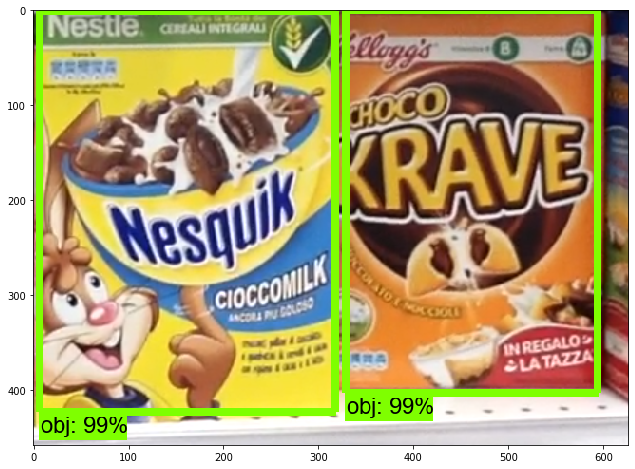

6.066671043634415 318.9999042749405 1.0896093845367432 422.36171448230743


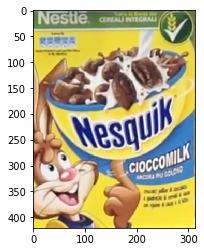

328.47997587919235 594.0504661202431 0.0 402.6283845901489


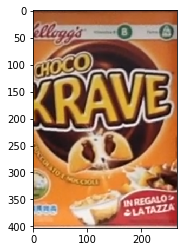

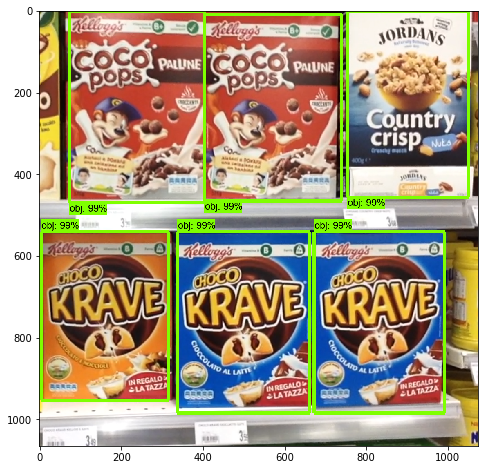

672.3514487743378 992.1025528907776 540.8261525630951 983.0839741230011


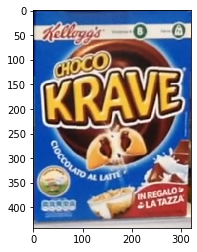

338.13497936725616 662.9859974384308 540.3933531045914 983.6027240753174


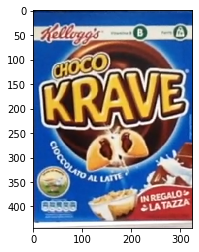

73.76568433642387 404.81782507896423 0.5579958111047745 468.80846232175827


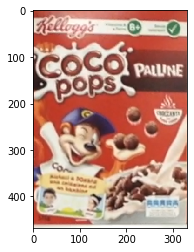

404.21684861183167 740.7890202999115 8.713151961565018 464.05436530709267


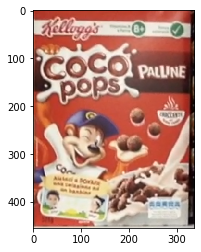

4.545092582702637 317.8084611296654 540.7327115535736 952.4566519260406


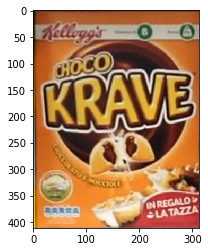

753.6137351989746 1050.651667356491 0.0 455.05879551172256


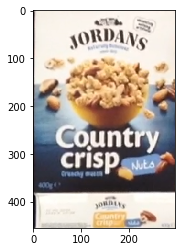

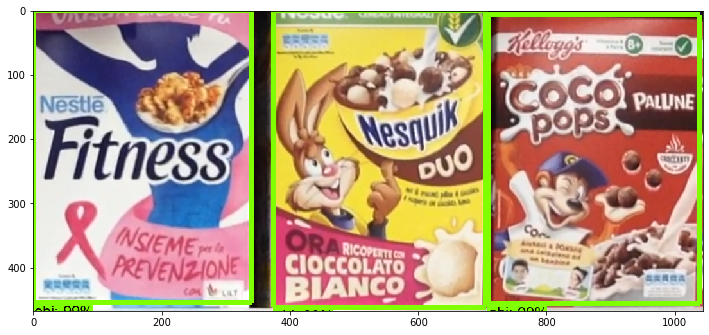

708.0393133163452 1038.9064507484436 7.7087202072143555 456.48844170570374


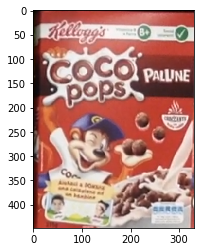

374.60940885543823 705.8934688568115 0.0 461.53190875053406


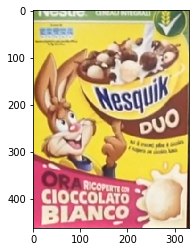

0.17255616188049316 340.73211658000946 0.0 454.90409088134766


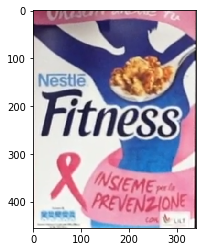

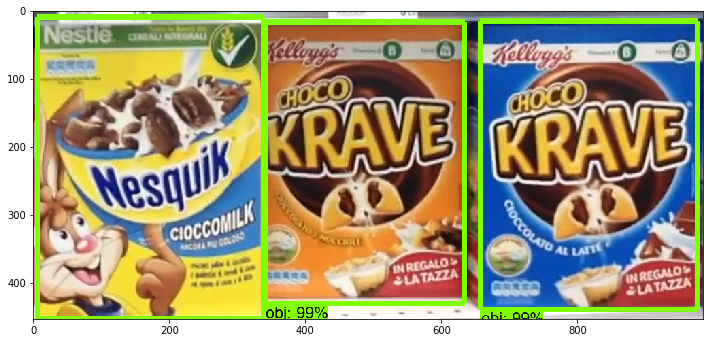

657.2909557819366 977.551389336586 15.457761079072952 438.1384323835373


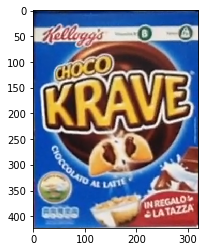

340.90547889471054 634.0992218255997 16.773150622844696 429.5914582014084


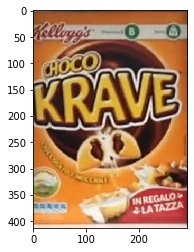

6.575349569320679 339.1256971657276 9.545791625976562 452.29975855350494


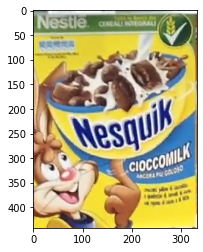

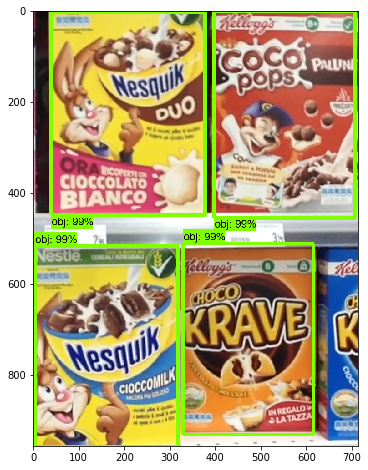

329.34876215457916 616.879163146019 511.98363304138184 930.498827457428


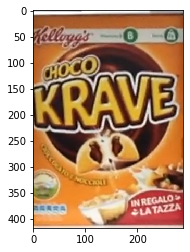

397.49583756923676 708.0669862031937 1.679517149925232 454.0063443183899


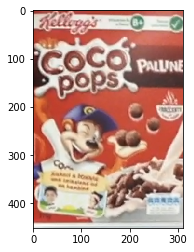

3.386051505804062 319.961678981781 517.8290786743164 956.0


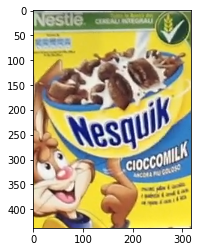

39.8109775185585 378.69473218917847 3.930051326751709 448.6037346124649


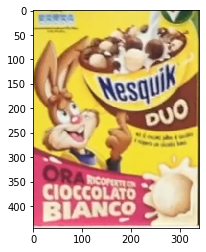

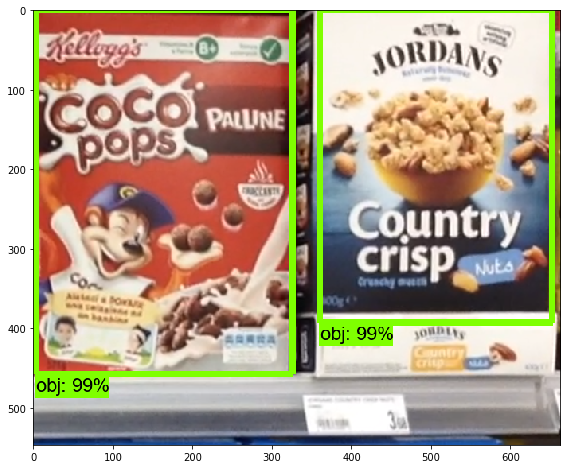

2.9628727734088898 326.28484520316124 0.0 457.73415315151215


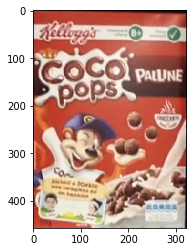

359.49719256162643 652.5862879157066 0.0 392.94041323661804


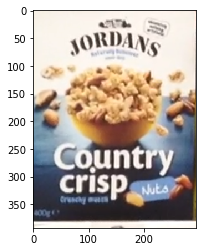

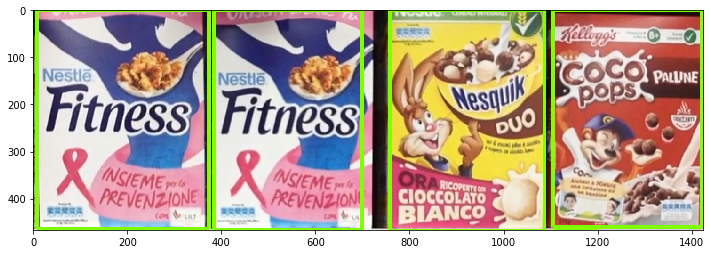

758.191089630127 1087.5565128326416 0.0 467.0


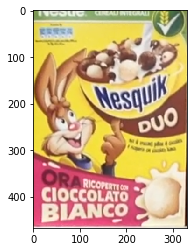

8.912022829055786 374.6232900619507 0.40366852283477783 464.7147440314293


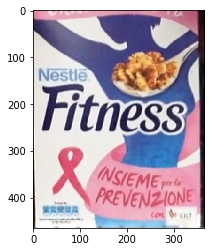

384.4023103713989 700.0626420974731 1.1134982705116272 465.95870667696


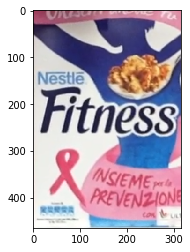

1105.0600204467773 1421.7840309143066 0.0 460.35597574710846


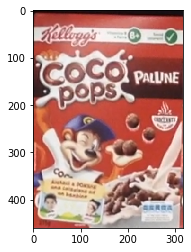

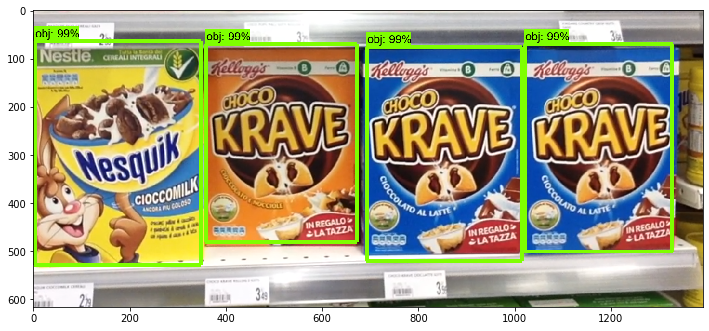

1020.7056766152382 1327.6569622159004 70.87765860557556 500.9770202636719


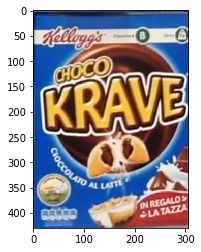

3.4289010241627693 348.09797352552414 64.53441262245178 528.825795173645


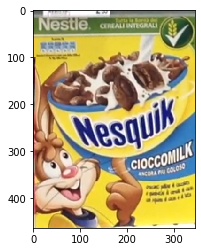

358.17270666360855 672.4505056142807 70.19010615348816 480.6236906051636


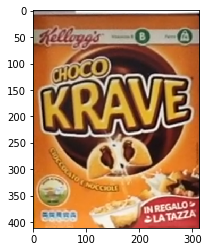

692.9898979067802 1015.3258085846901 76.73039102554321 519.6545372009277


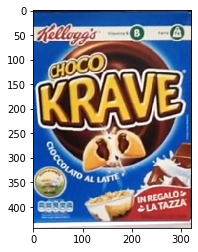

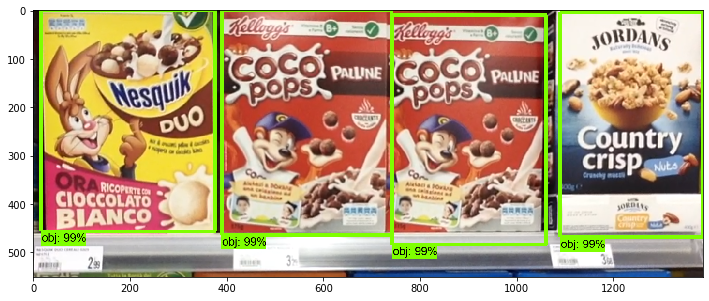

742.1986284852028 1061.3006004691124 10.273815631866455 483.75117951631546


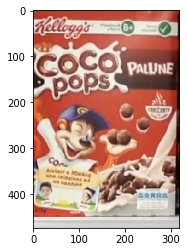

16.88063107430935 377.70280718803406 0.0 456.1756217479706


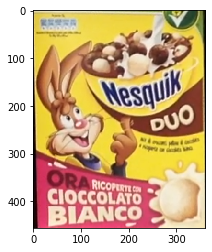

1089.968748986721 1385.0 4.093561679124832 468.87844347953796


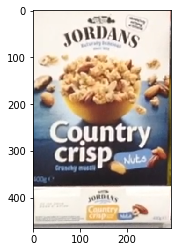

389.2155694961548 741.220794916153 0.0 464.02516055107117


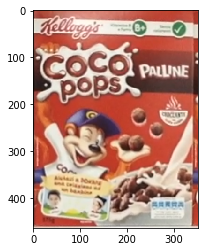

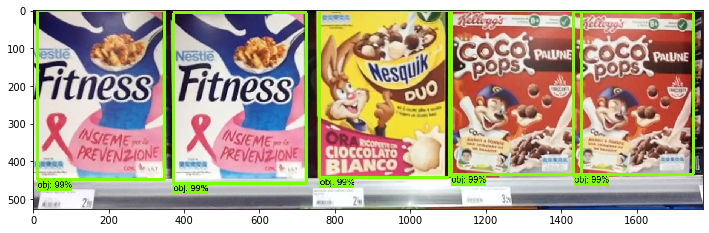

759.8261518478394 1103.3590078353882 0.0 441.21968603134155


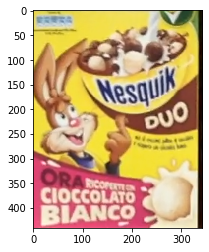

1107.0010471343994 1455.8943328857422 0.0 433.8193497657776


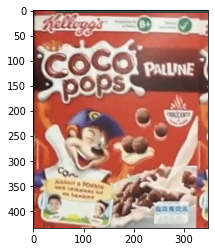

371.1382541656494 726.5505838394165 7.16580730676651 457.0881464481354


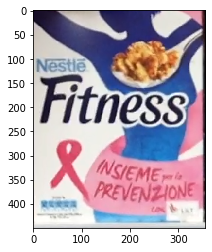

1433.931158065796 1750.7063255310059 4.369236409664154 433.3079979419708


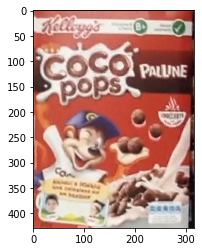

10.456770658493042 348.0618782043457 0.0 448.038316488266


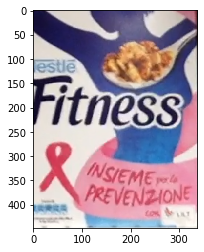

In [11]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.asarray(image)
    #image_np = cv2.cvtColor(image_np, cv2.COLOR_BGRA2RGBA)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)
    
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()
    
    # crop image and display
    im_width, im_height = image.size
    cropped_images = []
    for i in range(output_dict['num_detections']):
        if output_dict['detection_scores'][i] > 0.8:
            (ymin, xmin, ymax, xmax) = output_dict['detection_boxes'][i]
            (left, right, top, bottom) = (xmin * im_width, 
                                  xmax * im_width, 
                                  ymin * im_height, 
                                  ymax * im_height)
            print(left, right, top, bottom)
            cropped_image = image.crop((left, top, right, bottom))
            plt.imshow(cropped_image)
            plt.show()

In [12]:
output_dict

{'num_detections': 97,
 'detection_boxes': array([[0.        , 0.42783004, 0.8388207 , 0.6212607 ],
        [0.        , 0.62331134, 0.82475156, 0.8197604 ],
        [0.01362318, 0.20897424, 0.8689888 , 0.4090938 ],
        [0.0083065 , 0.8073938 , 0.82377934, 0.98575807],
        [0.        , 0.00588784, 0.85178393, 0.1959808 ],
        [0.3315469 , 0.5961911 , 1.        , 1.        ],
        [0.03570208, 0.87179416, 0.870371  , 0.972164  ],
        [0.34974122, 0.2477774 , 0.7999227 , 0.408234  ],
        [0.        , 0.10286599, 0.66725534, 0.80050755],
        [0.4570951 , 0.05500637, 0.82272655, 0.19685869],
        [0.        , 0.        , 0.62021816, 0.49627244],
        [0.24083686, 0.25597042, 1.        , 0.7324167 ],
        [0.1733994 , 0.        , 0.50693184, 0.37083012],
        [0.00362101, 0.714955  , 0.735376  , 1.        ],
        [0.3285129 , 0.6849959 , 0.6796999 , 1.        ],
        [0.04151285, 0.5935999 , 0.72916955, 0.9350203 ],
        [0.42091298, 0.       